## Giới thiệu Modeling

Mục tiêu của giai đoạn Modeling là xây dựng và đánh giá các mô hình dự đoán giá xe dựa trên tập dữ liệu đã được tiền xử lý và chọn lọc đặc trưng. Giai đoạn này tập trung vào việc kiểm tra nhiều thuật toán học máy, tối ưu hóa siêu tham số, và đánh giá hiệu quả mô hình thông qua các thước đo phù hợp.

Quy trình Modeling được tổ chức thành các phase rõ ràng như sau:

```
Phase I — Chuẩn bị dữ liệu cho Modeling
├── 1.1 Load dataset đã tiền xử lý
├── 1.2 Xác định tập đặc trưng (X) và biến mục tiêu (y)
├── 1.3 Chia dữ liệu thành tập Train và Test
├── 1.4 Kiểm tra tính tương thích của dữ liệu với mô hình
└── 1.5 Chuẩn bị chiến lược Feature Scaling


Phase II — Benchmark Models
├── 2.1 Linear Regression (Baseline)
├── 2.2 Ridge Regression
├── 2.3 Random Forest
├── 2.4 XGBoost / LightGBM
└── 2.5 CatBoost


Phase III — Hyperparameter Tuning & Cross-validation
├── 3.1 Xác định mô hình tiềm năng
├── 3.2 Thiết lập không gian siêu tham số
├── 3.3 GridSearchCV / RandomizedSearchCV
├── 3.4 K-fold Cross-validation
└── 3.5 Lựa chọn bộ siêu tham số tối ưu


Phase IV — Đánh giá mô hình (Evaluation)
├── 4.1 Đánh giá trên tập Test (RMSE, MAE, R²)
├── 4.2 So sánh Actual vs Predicted
├── 4.3 Phân tích Residual
├── 4.4 Phân phối lỗi dự đoán (Error Distribution)
└── 4.5 Tổng hợp kết quả đánh giá


Phase V — Lựa chọn mô hình & Giải thích
├── 5.1 So sánh hiệu suất giữa các mô hình
├── 5.2 Lựa chọn mô hình tối ưu
├── 5.3 Phân tích Feature Importance / SHAP
├── 5.4 Đánh giá ưu và nhược điểm của mô hình
└── 5.5 Kết luận và định hướng cải tiến
```

### Import thư viện cần thiết

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

## Phase I — Chuẩn bị dữ liệu cho Modeling

Giai đoạn này nhằm chuẩn bị toàn bộ dữ liệu đầu vào để đảm bảo mô hình có thể huấn luyện một cách ổn định, chính xác và có khả năng tổng quát hóa cao. Các bước thực hiện gồm:

### 1. Nạp và kiểm tra dataset cuối cùng
- Tải dataset sau khi hoàn tất toàn bộ preprocessing và encoding.
- Kiểm tra kích thước, kiểu dữ liệu, missing values và sự nhất quán của dữ liệu.

### 2. Xác định tập biến đặc trưng (X) và biến mục tiêu (y)
- Target: `price_million`
- X: toàn bộ các đặc trưng numerical + encoded categorical
- Kiểm tra số lượng đặc trưng và đảm bảo tất cả đã ở dạng number.

### 3. Train–test split
- Chia dữ liệu theo tỉ lệ 80% training – 20% testing.
- Kiểm tra phân phối target giữa train/test để đảm bảo không lệch phân phối.

### 4. Kiểm tra khả năng tương thích của dữ liệu với mô hình
- Đảm bảo không còn datatype dạng object.
- Không có NaN hoặc giá trị vô hạn.
- Kiểm tra thống kê mô tả để phát hiện vấn đề tiềm ẩn.

### 5. Chuẩn bị strategy cho Feature Scaling (nếu mô hình yêu cầu)
- Linear Regression, Lasso, Ridge, SVR, KNN cần scaling.
- Tree-based models (RF, XGB, LGBM, CatBoost) không cần scaling.
- Scaling sẽ được thực hiện trong Pipeline ở phase sau.

Sau Phase I, dữ liệu đã sẵn sàng hoàn toàn cho quá trình huấn luyện nhiều mô hình trong Phase II.

### 1. Load datasets

In [2]:
df = pd.read_csv('../datasets/preprocessed_car_features.csv')

### 2. Xác định tập đặc trưng (X) và biến mục tiêu (y)

Biến mục tiêu cho bài toán dự đoán là `price_million`.
Tập đặc trưng X bao gồm toàn bộ các biến còn lại

In [3]:
target_col = "price_million"

X = df.drop(columns=[target_col])
y = df[target_col]

print("Số lượng features:", X.shape[1])
X.columns.tolist()

Số lượng features: 69


['km',
 'seats',
 'engine',
 'engine_missing',
 'age',
 'km_per_year',
 'is_luxury',
 'usage',
 'transmission_binary',
 'fuel_diesel',
 'fuel_electric',
 'fuel_gasoline',
 'fuel_hybrid',
 'inland_binary',
 'new_binary',
 'body_type_convertible',
 'body_type_coupe',
 'body_type_hatchback',
 'body_type_minivan',
 'body_type_other',
 'body_type_pickup',
 'body_type_sedan',
 'body_type_suv',
 'body_type_truck',
 'body_type_wagon',
 'city_ba_ria',
 'city_bac_ninh',
 'city_binh_duong',
 'city_can_tho',
 'city_da_nang',
 'city_dak_lak',
 'city_dong_nai',
 'city_gia_lai',
 'city_ha_noi',
 'city_hai_phong',
 'city_ho_chi_minh',
 'city_lam_dong',
 'city_nghe_an',
 'city_other',
 'city_phu_tho',
 'city_quang_ninh',
 'city_thanh_hoa',
 'city_unknow',
 'city_vinh_phuc',
 'brand_audi',
 'brand_bmw',
 'brand_chevrolet',
 'brand_daewoo',
 'brand_ford',
 'brand_honda',
 'brand_hyundai',
 'brand_isuzu',
 'brand_kia',
 'brand_landrover',
 'brand_lexus',
 'brand_mazda',
 'brand_mercedes_benz',
 'brand_mg'

### 3. Chia dữ liệu thành tập Train và Test

Dữ liệu được chia theo tỷ lệ 80% huấn luyện và 20% kiểm tra.
Tập kiểm tra được dùng để đánh giá khả năng tổng quát hóa của mô hình trên dữ liệu mới.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (10869, 69)
Test shape: (2718, 69)


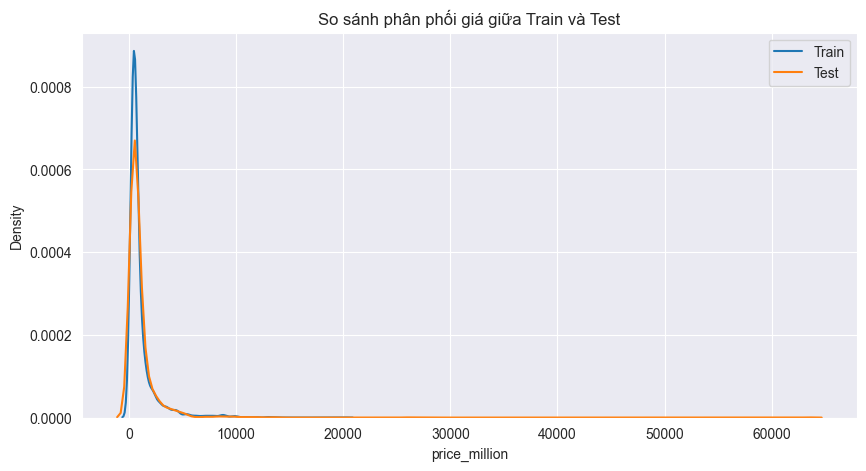

In [6]:
plt.figure(figsize=(10,5))
sns.kdeplot(y_train, label="Train")
sns.kdeplot(y_test, label="Test")
plt.legend()
plt.title("So sánh phân phối giá giữa Train và Test")
plt.show()

### 4. Kiểm tra tính tương thích của dữ liệu với mô hình

Mục tiêu:
- Đảm bảo không còn giá trị NaN sau train-test split.
- Đảm bảo toàn bộ feature ở dạng số (numeric).
- Kiểm tra các thống kê mô tả để phát hiện outliers còn sót lại hoặc giá trị bất thường.

In [7]:
X_train.isnull().sum().sort_values(ascending=False).head()

km                0
seats             0
engine            0
engine_missing    0
age               0
dtype: int64

In [8]:
X_train.dtypes.value_counts()

int64      63
float64     6
Name: count, dtype: int64

In [9]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
km,10869.0,58295.092051,60510.806031,0.000000,9000.000000,48000.000000,87000.000000,500000.000000
seats,10869.0,5.591591,1.116101,2.000000,5.000000,5.000000,7.000000,9.000000
engine,10869.0,1.370899,1.231650,0.000000,0.000000,1.500000,2.000000,10.000000
engine_missing,10869.0,0.366179,0.481781,0.000000,0.000000,0.000000,1.000000,1.000000
age,10869.0,5.972675,5.439811,0.000000,2.000000,5.000000,9.000000,30.000000
...,...,...,...,...,...,...,...,...
brand_toyota,10869.0,0.176925,0.381623,0.000000,0.000000,0.000000,0.000000,1.000000
brand_vinfast,10869.0,0.069188,0.253785,0.000000,0.000000,0.000000,0.000000,1.000000
brand_volkswagen,10869.0,0.011961,0.108714,0.000000,0.000000,0.000000,0.000000,1.000000
brand_volvo,10869.0,0.006900,0.082785,0.000000,0.000000,0.000000,0.000000,1.000000


### Nhận xét từ bảng thống kê mô tả

Tất cả các đặc trưng số trong X_train đều có phân phối hợp lý, phù hợp với domain của thị trường xe Việt Nam và không xuất hiện giá trị bất thường ngoài phạm vi đã được kiểm soát ở giai đoạn tiền xử lý. Một số nhận xét chính:

- Các biến `km`, `age`, `km_per_year` đều có phân phối lệch phải (right-skewed), đúng đặc tính dữ liệu xe cũ.
- Biến `seats` chỉ còn trong khoảng 2–9 chỗ, thể hiện quá trình làm sạch dữ liệu đã nhất quán.
- `engine` có giá trị 0 tại các trường hợp thiếu thông tin, được bổ sung bằng biến `engine_missing`, giúp mô hình phân biệt đúng bản chất của dữ liệu.
- Các biến nhị phân (`is_luxury`, `engine_missing`, `transmission_binary`, `fuel_diesel`) đều có phân phối hợp lý, không bị mất cân bằng nghiêm trọng.
- Không phát hiện outlier bất thường sau quá trình xử lý ban đầu.

Kết luận: **Dataset hoàn toàn phù hợp cho modeling, không cần xử lý thêm ở bước này.**

### 5. Chuẩn bị chiến lược Feature Scaling

Một số mô hình yêu cầu chuẩn hóa dữ liệu đầu vào, ví dụ:
- Linear Regression
- Ridge / Lasso
- SVR
- KNN

Các mô hình tree-based như Random Forest, XGBoost, LightGBM, CatBoost không yêu cầu scaling.

Scaling sẽ được thực hiện trong Pipeline của từng mô hình trong Phase II.

## Phase II — Benchmarking các mô hình học máy

Trong giai đoạn này, mục tiêu của chúng ta là xây dựng và so sánh nhiều thuật toán học máy khác nhau để xác định mô hình phù hợp nhất cho bài toán dự đoán giá xe. Đây là bước quan trọng để hiểu rõ mức độ phức tạp của dữ liệu, khả năng mô hình hóa quan hệ phi tuyến, và giới hạn của từng thuật toán.

### Mục tiêu của Phase II
1. Huấn luyện nhiều mô hình khác nhau (baseline + advanced models).
2. Đánh giá hiệu suất của từng mô hình trên tập kiểm tra.
3. Xác định mô hình nào có tiềm năng nhất để tiếp tục tối ưu trong Phase III.
4. Tạo đường chuẩn (baseline) giúp so sánh việc cải thiện trong các bước sau.

### Các nhóm mô hình được sử dụng
Phase II sẽ bao gồm hai nhóm thuật toán chính:

#### 1) **Mô hình tuyến tính (Baseline Models)**
- Linear Regression
- Ridge Regression
- Lasso Regression
Nhóm này giúp thiết lập baseline và kiểm tra xem dữ liệu có tuyến tính hay không.

#### 2) **Mô hình phi tuyến (Advanced Tree-based Models)**
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM
- CatBoost
Nhóm này mạnh trong dự đoán giá xe vì có khả năng xử lý quan hệ phi tuyến, tương tác biến và phân phối lệch (skewed distribution).

### Cách đánh giá mô hình
Tất cả mô hình sẽ được đánh giá bằng bộ chỉ số chuẩn cho bài toán regression:
- **RMSE** (độ lệch nghiêm trọng, nhạy với outlier)
- **MAE** (độ lệch tuyệt đối, dễ diễn giải)
- **R²** (mức độ giải thích)

Mục tiêu:
**Chọn mô hình có tổng thể hiệu suất tốt nhất trên tập kiểm tra, ổn định, và phù hợp với đặc trưng dữ liệu.**

Trong các phần tiếp theo, chúng ta sẽ lần lượt xây dựng Pipeline, huấn luyện từng mô hình và so sánh kết quả bằng bảng tổng hợp.

### 2.1 Linear Regression (Baseline)

Linear Regression được sử dụng như mô hình baseline cho bài toán dự đoán giá xe. Mục tiêu của mô hình này không phải đạt độ chính xác cao nhất, mà là thiết lập một đường chuẩn (baseline) để so sánh với các mô hình phức tạp hơn trong các bước tiếp theo.

Mô hình Linear Regression giả định mối quan hệ tuyến tính giữa biến mục tiêu (`price_million`) và các đặc trưng đầu vào. Do dữ liệu giá xe thường có quan hệ phi tuyến và phân phối lệch, mô hình này giúp đánh giá mức độ phù hợp của giả định tuyến tính đối với bài toán.

Trước khi huấn luyện, dữ liệu được chuẩn hóa bằng Feature Scaling nhằm đảm bảo các đặc trưng có cùng thang đo, giúp quá trình tối ưu của mô hình ổn định hơn.

Kết quả từ Linear Regression sẽ được đánh giá bằng các thước đo RMSE, MAE và R² trên tập kiểm tra. Các giá trị này sẽ đóng vai trò là mốc tham chiếu khi so sánh với các mô hình nâng cao như Random Forest, XGBoost, LightGBM và CatBoost.

In [13]:
# Pipeline cho Linear Regression (có scaling)
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Huấn luyện mô hình
%time lr_pipeline.fit(X_train, y_train)

CPU times: total: 46.9 ms
Wall time: 64.6 ms


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [14]:
# Dự đoán trên tập test
y_pred_lr = lr_pipeline.predict(X_test)

In [16]:
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE : {mae_lr:.2f}")
print(f"R²  : {r2_lr:.4f}")

Linear Regression Performance:
RMSE: 1422.62
MAE : 302.23
R²  : 0.4343


In [17]:
# Lưu kết quả vào dictionary để so sánh sau
model_results = {"Linear Regression": {
    "RMSE": rmse_lr,
    "MAE": mae_lr,
    "R2": r2_lr
}}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696}}

### Nhận xét kết quả Linear Regression

Linear Regression được sử dụng như mô hình baseline cho bài toán dự đoán giá xe. Kết quả cho thấy mô hình đạt R² ≈ 0.43, nghĩa là chỉ giải thích được khoảng 43% phương sai của biến mục tiêu. Sai số RMSE và MAE vẫn ở mức tương đối cao, đặc biệt đối với các xe có giá trị lớn.

Điều này phản ánh hạn chế của giả định tuyến tính trong khi dữ liệu giá xe có nhiều mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng. Kết quả từ mô hình baseline này sẽ được sử dụng làm mốc so sánh cho các mô hình nâng cao ở các bước tiếp theo.

### 2.2 Ridge Regression

Ridge Regression là phiên bản mở rộng của Linear Regression với cơ chế regularization L2, giúp hạn chế hiện tượng overfitting và giảm độ nhạy của mô hình đối với các đặc trưng có tương quan cao. Mô hình này đặc biệt hữu ích trong bối cảnh dữ liệu có số lượng đặc trưng lớn và nhiều biến được mã hóa one-hot như trong bài toán này.

Mục tiêu của Ridge Regression trong Phase II là kiểm tra xem việc áp dụng regularization có giúp cải thiện hiệu suất so với Linear Regression baseline hay không, đồng thời đánh giá độ ổn định của mô hình tuyến tính khi xử lý dữ liệu có tính phức tạp cao.


In [19]:
# Pipeline cho Ridge Regression (có scaling)
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])

# Huấn luyện mô hình
%time ridge_pipeline.fit(X_train, y_train)


CPU times: total: 31.2 ms
Wall time: 39.9 ms


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [20]:
# Dự đoán trên tập test
y_pred_ridge = ridge_pipeline.predict(X_test)

In [21]:
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Performance:")
print(f"RMSE: {rmse_ridge:.2f}")
print(f"MAE : {mae_ridge:.2f}")
print(f"R²  : {r2_ridge:.4f}")

Ridge Regression Performance:
RMSE: 1422.90
MAE : 302.23
R²  : 0.4341


In [22]:
# Lưu kết quả vào dictionary để so sánh
model_results["Ridge Regression"] = {
    "RMSE": rmse_ridge,
    "MAE": mae_ridge,
    "R2": r2_ridge
}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696},
 'Ridge Regression': {'RMSE': np.float64(1422.8962644293563),
  'MAE': 302.22879290254684,
  'R2': 0.434092589205031}}

### So sánh Linear Regression và Ridge Regression

Kết quả cho thấy Ridge Regression với regularization L2 (alpha = 1.0) không cải thiện đáng kể so với Linear Regression baseline. Các chỉ số RMSE, MAE và R² của hai mô hình gần như tương đương.

Điều này cho thấy rằng, mặc dù Ridge Regression giúp ổn định mô hình trong trường hợp đa cộng tuyến, nhưng với tập dữ liệu hiện tại — nơi các vấn đề đa cộng tuyến nghiêm trọng đã được xử lý trước đó — việc áp dụng regularization không mang lại cải thiện rõ rệt. Ngoài ra, kết quả cũng phản ánh hạn chế chung của các mô hình tuyến tính trong việc mô hình hóa các mối quan hệ phi tuyến và tương tác phức tạp trong dữ liệu giá xe.

Do đó, các mô hình phi tuyến sẽ được xem xét trong các bước tiếp theo.

### 2.3 Random Forest

Random Forest là mô hình phi tuyến dựa trên tập hợp nhiều cây quyết định (ensemble learning). Khác với các mô hình tuyến tính, Random Forest có khả năng học các mối quan hệ phi tuyến và các tương tác phức tạp giữa các đặc trưng, điều rất quan trọng trong bài toán dự đoán giá xe.

Trong Phase II, Random Forest được sử dụng như mô hình phi tuyến đầu tiên để kiểm tra mức độ cải thiện hiệu suất so với các mô hình tuyến tính (Linear và Ridge Regression). Mô hình này không yêu cầu chuẩn hóa dữ liệu và có khả năng xử lý tốt dữ liệu có phân phối lệch và nhiều đặc trưng đã được mã hóa one-hot.

In [25]:
# Khởi tạo Random Forest (cấu hình cơ bản để benchmark)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Huấn luyện mô hình
%time rf_model.fit(X_train, y_train)

CPU times: total: 21.7 s
Wall time: 2.09 s


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
# Dự đoán trên tập test
y_pred_rf = rf_model.predict(X_test)

In [27]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE : {mae_rf:.2f}")
print(f"R²  : {r2_rf:.4f}")

Random Forest Performance:
RMSE: 1215.44
MAE : 149.17
R²  : 0.5871


In [28]:
# Lưu kết quả vào dictionary để so sánh
model_results["Random Forest"] = {
    "RMSE": rmse_rf,
    "MAE": mae_rf,
    "R2": r2_rf
}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696},
 'Ridge Regression': {'RMSE': np.float64(1422.8962644293563),
  'MAE': 302.22879290254684,
  'R2': 0.434092589205031},
 'Random Forest': {'RMSE': np.float64(1215.4360386757173),
  'MAE': 149.17389171046145,
  'R2': 0.5870826593917611}}

### So sánh các mô hình trong Phase II

Kết quả benchmark cho thấy các mô hình tuyến tính (Linear Regression và Ridge Regression) đạt hiệu suất tương đương nhau với R² khoảng 0.43, phản ánh hạn chế của giả định tuyến tính trong bài toán dự đoán giá xe.

Ngược lại, Random Forest cho thấy sự cải thiện rõ rệt với RMSE và MAE giảm đáng kể, đồng thời R² tăng lên khoảng 0.59. Điều này cho thấy dữ liệu giá xe chứa nhiều mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng mà các mô hình tuyến tính không thể mô hình hóa hiệu quả.

Do đó, các mô hình phi tuyến sẽ tiếp tục được xem xét và tối ưu trong các bước tiếp theo.

### 2.4 XGBoost / LightGBM

XGBoost và LightGBM là các mô hình Gradient Boosting dựa trên cây quyết định, được thiết kế để xử lý dữ liệu dạng bảng (tabular data) với hiệu suất cao. So với Random Forest, các mô hình boosting có khả năng học tốt hơn các mối quan hệ phi tuyến phức tạp thông qua việc xây dựng cây tuần tự, trong đó mỗi cây mới tập trung sửa lỗi của các cây trước đó.

Trong Phase II, mô hình boosting được sử dụng để kiểm tra mức độ cải thiện hiệu suất so với Random Forest, đồng thời đánh giá tiềm năng đạt độ chính xác cao hơn cho bài toán dự đoán giá xe.

In [30]:
# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Huấn luyện mô hình
%time lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 10869, number of used features: 68
[LightGBM] [Info] Start training from score 1047.236049
CPU times: total: 4.89 s
Wall time: 528 ms


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [31]:
# Dự đoán trên tập test
y_pred_lgb = lgb_model.predict(X_test)

In [32]:
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("LightGBM Performance:")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"MAE : {mae_lgb:.2f}")
print(f"R²  : {r2_lgb:.4f}")


LightGBM Performance:
RMSE: 1169.11
MAE : 158.95
R²  : 0.6180


In [33]:
model_results["LightGBM"] = {
    "RMSE": rmse_lgb,
    "MAE": mae_lgb,
    "R2": r2_lgb
}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696},
 'Ridge Regression': {'RMSE': np.float64(1422.8962644293563),
  'MAE': 302.22879290254684,
  'R2': 0.434092589205031},
 'Random Forest': {'RMSE': np.float64(1215.4360386757173),
  'MAE': 149.17389171046145,
  'R2': 0.5870826593917611},
 'LightGBM': {'RMSE': np.float64(1169.105988136003),
  'MAE': 158.9549981975679,
  'R2': 0.6179619033017173}}

### So sánh các mô hình trong Phase II

LightGBM cho thấy khả năng cải thiện hiệu suất so với các mô hình đã thử nghiệm trước đó trong Phase II. Mô hình đạt RMSE ≈ 1169 và R² ≈ 0.62, cho thấy mức độ giải thích phương sai của biến mục tiêu được nâng lên đáng kể so với các mô hình tuyến tính và Random Forest.

Kết quả này phản ánh hiệu quả của cơ chế Gradient Boosting trong việc học các mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng, đặc biệt trong bối cảnh dữ liệu giá xe có phân phối lệch và nhiều yếu tố ảnh hưởng đồng thời. LightGBM cho thấy tiềm năng tốt để tiếp tục tối ưu hóa ở các bước tiếp theo.

### 2.5 CatBoost

CatBoost là mô hình Gradient Boosting dựa trên cây quyết định, được thiết kế đặc biệt cho dữ liệu dạng bảng (tabular data). Mô hình này có khả năng xử lý tốt các mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng, đồng thời có cơ chế regularization hiệu quả giúp giảm overfitting.

Trong Phase II, CatBoost được sử dụng để so sánh với các mô hình boosting khác như LightGBM, nhằm đánh giá liệu mô hình này có thể tiếp tục cải thiện hiệu suất dự đoán giá xe hay không.

In [35]:
# Khởi tạo CatBoost (cấu hình benchmark)
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    random_state=42,
    verbose=False
)

# Huấn luyện mô hình
%time cat_model.fit(X_train, y_train)

CPU times: total: 23.3 s
Wall time: 4.11 s


In [36]:
# Dự đoán trên tập test
y_pred_cat = cat_model.predict(X_test)

In [37]:
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
mae_cat = mean_absolute_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print("CatBoost Performance:")
print(f"RMSE: {rmse_cat:.2f}")
print(f"MAE : {mae_cat:.2f}")
print(f"R²  : {r2_cat:.4f}")

CatBoost Performance:
RMSE: 1207.76
MAE : 161.02
R²  : 0.5923


In [38]:
# Lưu kết quả vào dictionary để so sánh
model_results["CatBoost"] = {
    "RMSE": rmse_cat,
    "MAE": mae_cat,
    "R2": r2_cat
}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696},
 'Ridge Regression': {'RMSE': np.float64(1422.8962644293563),
  'MAE': 302.22879290254684,
  'R2': 0.434092589205031},
 'Random Forest': {'RMSE': np.float64(1215.4360386757173),
  'MAE': 149.17389171046145,
  'R2': 0.5870826593917611},
 'LightGBM': {'RMSE': np.float64(1169.105988136003),
  'MAE': 158.9549981975679,
  'R2': 0.6179619033017173},
 'CatBoost': {'RMSE': np.float64(1207.7582989322168),
  'MAE': 161.02188381166448,
  'R2': 0.592282865233647}}

### So sánh các mô hình trong Phase II

CatBoost đạt hiệu suất dự đoán tốt với RMSE ≈ 1208 và R² ≈ 0.59, cho thấy mô hình có khả năng mô hình hóa hiệu quả các mối quan hệ phi tuyến trong dữ liệu giá xe. Kết quả này thể hiện sự cải thiện rõ rệt so với các mô hình tuyến tính và tiệm cận với Random Forest trong cùng điều kiện benchmark.

Mặc dù hiệu suất của CatBoost trong cấu hình hiện tại chưa vượt LightGBM, mô hình vẫn cho thấy độ ổn định tốt và khả năng tổng quát hóa đáng tin cậy. Điều này cho thấy CatBoost là một ứng viên phù hợp để tiếp tục tối ưu hóa siêu tham số ở các bước tiếp theo nhằm khai thác tốt hơn tiềm năng của mô hình.

### Nhận xét tổng Phase II

Kết quả benchmark cho thấy sự khác biệt rõ rệt giữa các nhóm mô hình được sử dụng trong Phase II. Các mô hình tuyến tính (Linear Regression và Ridge Regression) cho hiệu suất tương đương nhau với R² khoảng 0.43, phản ánh hạn chế của giả định tuyến tính trong bối cảnh dữ liệu giá xe có nhiều mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng.

Random Forest mang lại sự cải thiện đáng kể so với các mô hình tuyến tính nhờ khả năng mô hình hóa các mối quan hệ phi tuyến và tương tác giữa các biến đầu vào. Tuy nhiên, các mô hình boosting như LightGBM và CatBoost tiếp tục nâng cao hiệu suất dự đoán, cho thấy ưu thế của cơ chế học tuần tự trong việc giảm sai số còn tồn tại.

Trong số các mô hình được thử nghiệm, LightGBM đạt hiệu suất cao nhất ở cấu hình benchmark với RMSE thấp nhất và R² cao nhất, trong khi CatBoost cho kết quả ổn định và tiệm cận. Kết quả này cho thấy các mô hình boosting là hướng tiếp cận phù hợp cho bài toán dự đoán giá xe và là ứng viên chính để tiếp tục tối ưu hóa siêu tham số trong Phase III.
